In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
import hist

hep.style.use("CMS")
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
scripts = ['suep_single_train.py', 'suep_double_train.py']
disco_vars = ['ntracks', 'S1']
objs = ['Pfcand', 'bPfcand']
lambdas = [1, 2, 5]

# loop over configurations
dirs = []
for script in scripts:
    for l in lambdas:
        for obj in objs:
            for disco_var in disco_vars:
                
                # define outDir string
                if script != 'suep_single_train.py':
                    # no need to loop over disco_vars if double disco
                    if disco_var != disco_vars[0]: 
                        continue
                    else:
                        outDir = script.split("_")[1] + "_l" + str(l) + "_" + obj
                else:
                    outDir = script.split("_")[1] + "_l" + str(l) + "_" + obj + "_" + disco_var
                
                dirs.append(outDir)

In [3]:
results = []
for inputDir in dirs:
    results.append(np.load("{}/disco_results.npy".format(inputDir)))

In [4]:
out_dir = '/home/submit/lavezzo/public_html/SUEP/ParticleNet/grid_search/'
if not os.path.isdir(out_dir): os.system("mkdir " + out_dir)

In [5]:
dirs

['single_l1_Pfcand_ntracks',
 'single_l1_Pfcand_S1',
 'single_l1_bPfcand_ntracks',
 'single_l1_bPfcand_S1',
 'single_l2_Pfcand_ntracks',
 'single_l2_Pfcand_S1',
 'single_l2_bPfcand_ntracks',
 'single_l2_bPfcand_S1',
 'single_l5_Pfcand_ntracks',
 'single_l5_Pfcand_S1',
 'single_l5_bPfcand_ntracks',
 'single_l5_bPfcand_S1',
 'double_l1_Pfcand',
 'double_l1_bPfcand',
 'double_l2_Pfcand',
 'double_l2_bPfcand',
 'double_l5_Pfcand',
 'double_l5_bPfcand']

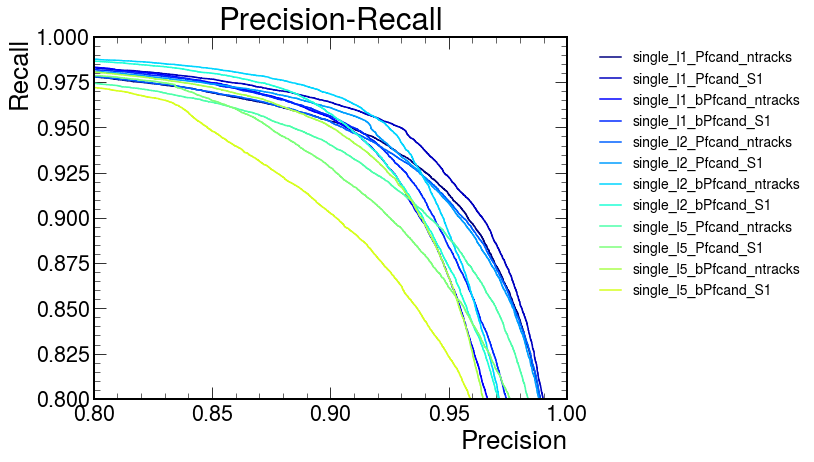

In [7]:
from sklearn.metrics import precision_recall_curve

fig = plt.figure(figsize=(12,7))
ax = fig.subplots()
cmap = plt.cm.jet(np.linspace(0, 1, len(dirs)+1))

y_preds = [r[0] for r in results]
y_tests = [r[2] for r in results]
        
for key, y_pred, y_test, color in zip(dirs, y_preds, y_tests, cmap):
    if 'single' not in key: continue
    pre, rec, _ = precision_recall_curve(y_test, y_pred)
    ax.plot(rec, pre, label=key, color=color)

ax.set_xlabel("Precision")
ax.set_ylabel("Recall")
ax.set_title("Precision-Recall")

ax.set_ylim(0.8,1.0)
ax.set_xlim(0.8,1.0)

ax.legend(fontsize=14, framealpha=1, facecolor='white', shadow=True, bbox_to_anchor=(1.04,1), loc="upper left")
fig.tight_layout()
fig.savefig('{}/precision-recall-curve'.format(out_dir), bbox_inches='tight')

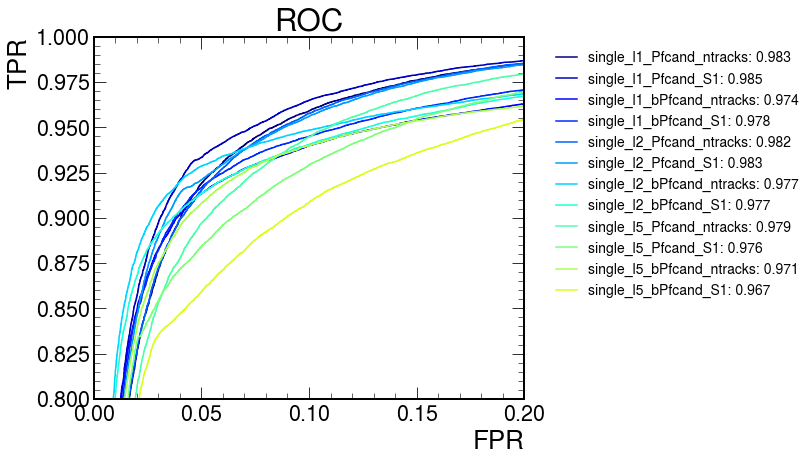

In [8]:
from sklearn.metrics import roc_curve, auc

fig = plt.figure(figsize=(12,7))
ax = fig.subplots()
cmap = plt.cm.jet(np.linspace(0, 1, len(dirs)+1))

y_preds = [r[0] for r in results]
y_tests = [r[2] for r in results]
        
aucs = []
for key, y_pred, y_test, color in zip(dirs, y_preds, y_tests, cmap):
    if 'single' not in key: continue
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    aucs.append(auc(fpr, tpr))
    ax.plot(fpr, tpr, label=key + ": " + str(round(auc(fpr, tpr),3)), color=color)

ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("ROC")

ax.set_xlim(0.0,0.2)
ax.set_ylim(0.8,1.0)

ax.legend(fontsize=14, framealpha=1, facecolor='white', shadow=True, bbox_to_anchor=(1.04,1), loc="upper left")
fig.tight_layout()
fig.savefig('{}/roc-curve'.format(out_dir), bbox_inches='tight')

In [18]:
def get2dHists(r, xmax=None, ymax=None, xlabel='var1', ylabel='var2'):
    suep_cl1 = r[0][r[2] == 1]
    suep_cl2 = r[1][r[2] == 1]
    qcd_cl1 = r[0][r[2] == 0]
    qcd_cl2 = r[1][r[2] == 0]

    if xmax is None: xmax = np.max([np.max(qcd_cl1),np.max(suep_cl1)])
    if ymax is None: ymax = np.max([np.max(qcd_cl2),np.max(suep_cl2)])
    
    hist_abcd = (
         hist.new
        .Regular(100, 0, xmax, name="var1", label=xlabel)
        .Regular(100, 0, ymax, name="var2", label=ylabel)
        .Weight()
    )

    hist_abcd.fill(qcd_cl1, qcd_cl2)

    hist_abcd_suep = (
         hist.new
        .Regular(100, 0, xmax, name="var1", label=xlabel)
        .Regular(100, 0, ymax, name="var2", label=ylabel)
        .Weight()
    )

    hist_abcd_suep.fill(suep_cl1, suep_cl2)
    
    return hist_abcd, hist_abcd_suep

def getSRClosure_4regions(hist_abcd, xregions, yregions):
    A = hist_abcd[xregions[0]:xregions[1]:sum,yregions[0]:yregions[1]]
    B = hist_abcd[xregions[0]:xregions[1]:sum,yregions[1]:yregions[2]]
    C = hist_abcd[xregions[1]:xregions[2]:sum,yregions[0]:yregions[1]]
    D = hist_abcd[xregions[1]:xregions[2]:sum,yregions[1]:yregions[2]]
    D_exp = B * C.sum().value/A.sum().value

    ratio = D.sum().value/D_exp.sum().value
    
    return D, D_exp, ratio

def getSRClosure_6regions(hist_abcd, xregions, yregions):
    A = hist_abcd[xregions[0]:xregions[1]:sum,yregions[0]:yregions[1]]
    B = hist_abcd[xregions[0]:xregions[1]:sum,yregions[1]:yregions[2]]
    C = hist_abcd[xregions[0]:xregions[1]:sum,yregions[2]:yregions[3]]
    D = hist_abcd[xregions[1]:xregions[2]:sum,yregions[0]:yregions[1]]
    E = hist_abcd[xregions[1]:xregions[2]:sum,yregions[1]:yregions[2]]
    F = hist_abcd[xregions[1]:xregions[2]:sum,yregions[2]:yregions[3]]
    F_exp = C * E.sum().value**2 * A.sum().value / (B.sum().value**2 * D.sum().value)

    ratio = F.sum().value/F_exp.sum().value
    
    return F, F_exp, ratio

def precision_recall_2variables(y_pred1, y_pred2, y_true, xsecs=None, ysecs=None):
    
    if xsecs is None: xsecs = np.linspace(np.min(y_pred1),np.max(y_pred1),20)
    if ysecs is None: ysecs = np.linspace(np.min(y_pred2),np.max(y_pred2),20)
    
    pres, recs, s_over_sqrtB = [], [], []
    for x in xsecs:
        for y in ysecs:
            
            TP = np.sum(y_true[(y_pred1>x) & (y_pred2>y)]) # how many 1's in y_true predicted
            FP = len(y_true[(y_pred1>x) & (y_pred2>y)]) - TP # total predicted P minus TP
            FN = np.sum(y_true[(y_pred1<x) | (y_pred2<y)]) # how many 1's in y_true not predicted
            
            if TP + FP == 0: pre = None
            else: pre = TP / (TP + FP)
            if TP + FN == 0: rec = None
            else: rec = TP / (TP + FN)
            
            pres.append(pre)
            recs.append(rec)
            
    return pres, recs

def closure_significance_2variables(results, xsecs=None, ysecs=None):
    
    y_pred1 = results[0]
    y_pred2 = results[1]
    y_test = results[2]
    
    if xsecs is None: xsecs = np.linspace(np.min(y_pred1),np.max(y_pred1),20)
    if ysecs is None: ysecs = np.linspace(np.min(y_pred2),np.max(y_pred2),20)

    hist_abcd, hist_abcd_suep = get2dHists(results)
    
    ratios, sigs = [], []
    for x in xsecs:
        for y in ysecs:
            
            xregions = [0.05j, x*1j, 1.0j]
            if y <= 1.0: yregions = [0.0j, 1j*(y+0.0)/2.0, y*1j, 1.0j]
            else: yregions = [10j, 1j*(y+10.0)/2.0, y*1j, 300j]
                        
            F, F_exp, ratio = getSRClosure(hist_abcd, xregions, yregions)
            
            s = hist_abcd_suep[xregions[-2]:xregions[-1],yregions[-2]:yregions[-1]].sum().value
            bkg = hist_abcd[xregions[-2]:xregions[-1],yregions[-2]:yregions[-1]].sum().value
            sig = s/np.sqrt(bkg)
            
            ratios.append(ratio)
            sigs.append(sig)
            
    return ratios, sigs

single_l1_Pfcand_ntracks
	SR Closure: 0.95
	Precision: 0.98
	Recall: 0.32
single_l1_Pfcand_S1
	SR Closure: 0.67
	Precision: 0.98
	Recall: 0.79
single_l1_bPfcand_ntracks
	SR Closure: 0.59
	Precision: 0.99
	Recall: 0.31
single_l1_bPfcand_S1
	SR Closure: 0.67
	Precision: 0.98
	Recall: 0.8
single_l2_Pfcand_ntracks
	SR Closure: 1.01
	Precision: 0.98
	Recall: 0.32
single_l2_Pfcand_S1
	SR Closure: 0.98
	Precision: 0.98
	Recall: 0.78
single_l2_bPfcand_ntracks
	SR Closure: 0.49
	Precision: 0.99
	Recall: 0.31
single_l2_bPfcand_S1
	SR Closure: 0.75
	Precision: 0.98
	Recall: 0.79
single_l5_Pfcand_ntracks
	SR Closure: 1.36
	Precision: 0.98
	Recall: 0.31
single_l5_Pfcand_S1
	SR Closure: 1.26
	Precision: 0.98
	Recall: 0.77
single_l5_bPfcand_ntracks
	SR Closure: 0.9
	Precision: 0.99
	Recall: 0.31
single_l5_bPfcand_S1
	SR Closure: 0.94
	Precision: 0.97
	Recall: 0.78
double_l1_Pfcand
	SR Closure: 7.58
	Precision: 0.96
	Recall: 0.89
double_l1_bPfcand
	SR Closure: 15.95
	Precision: 0.99
	Recall: 0.86
doub

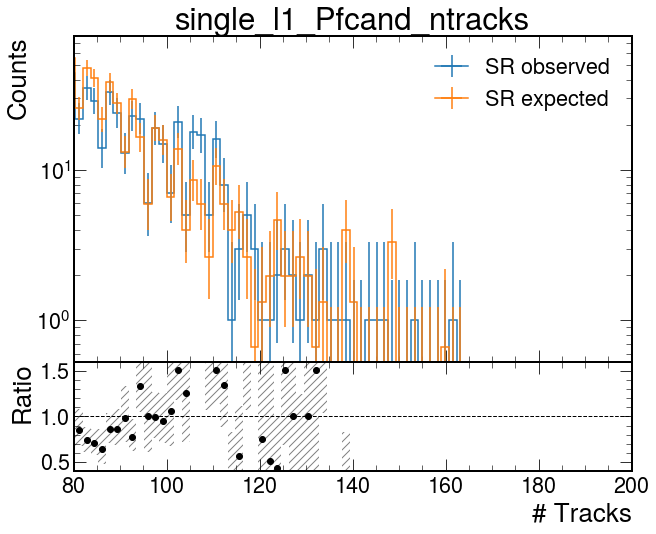

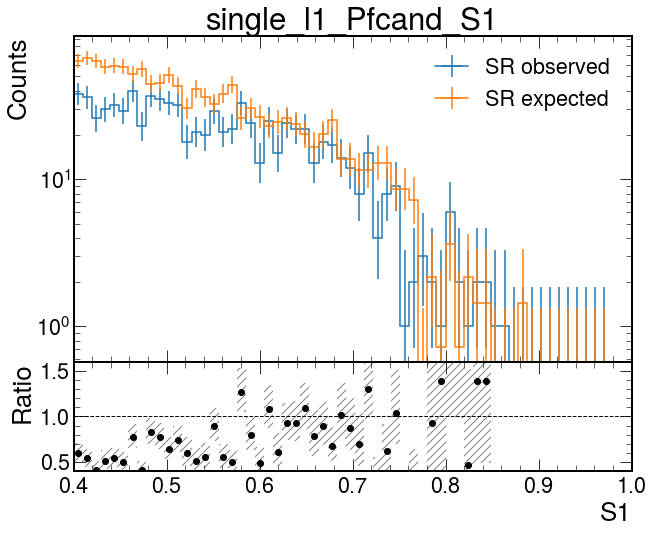

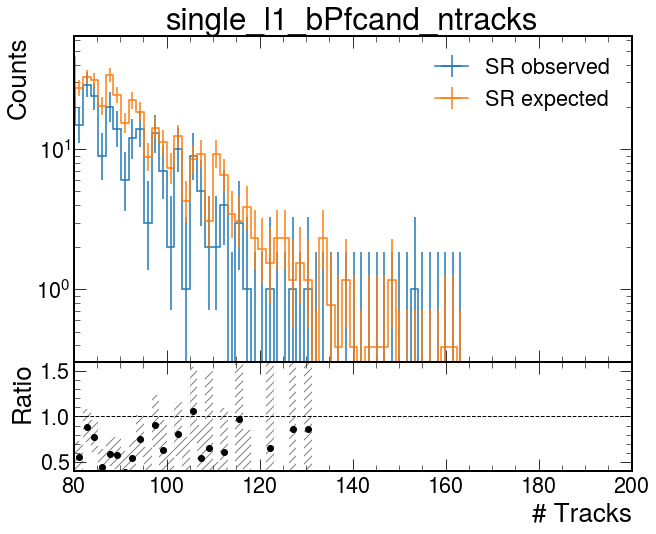

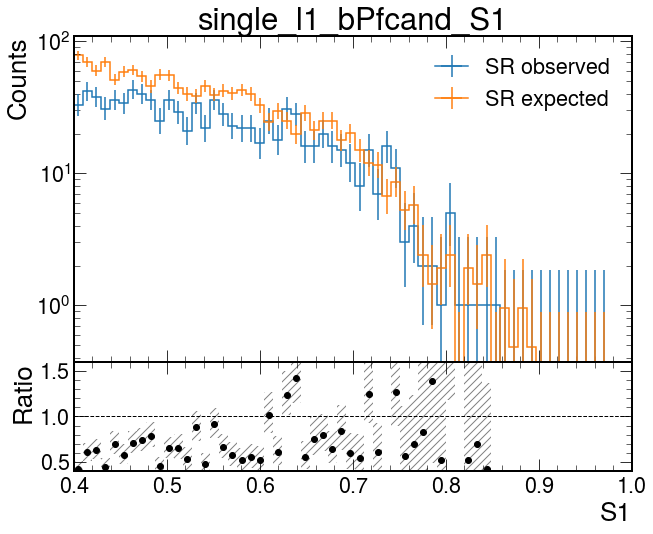

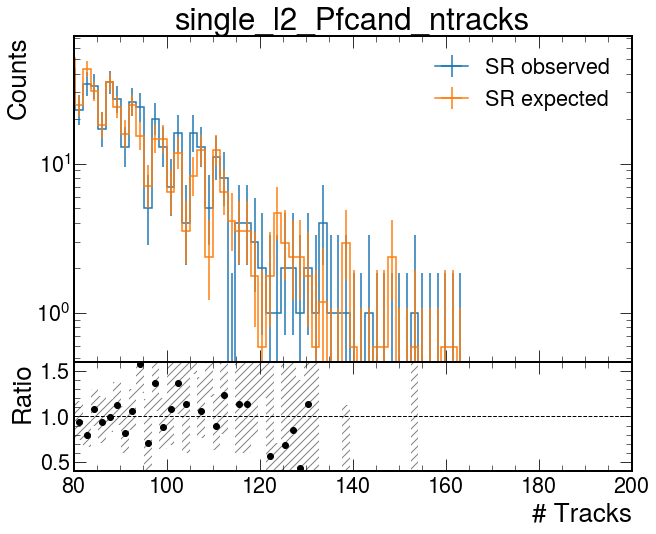

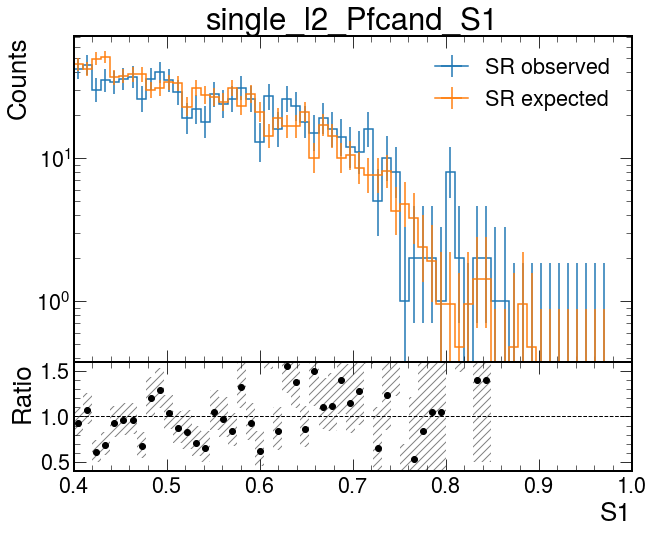

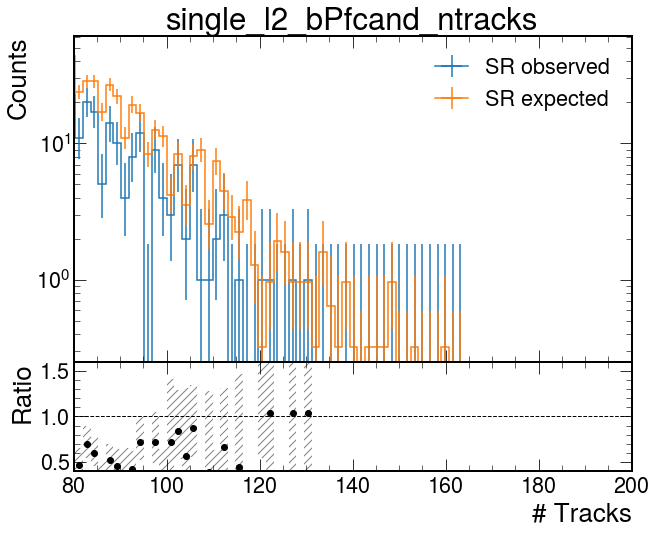

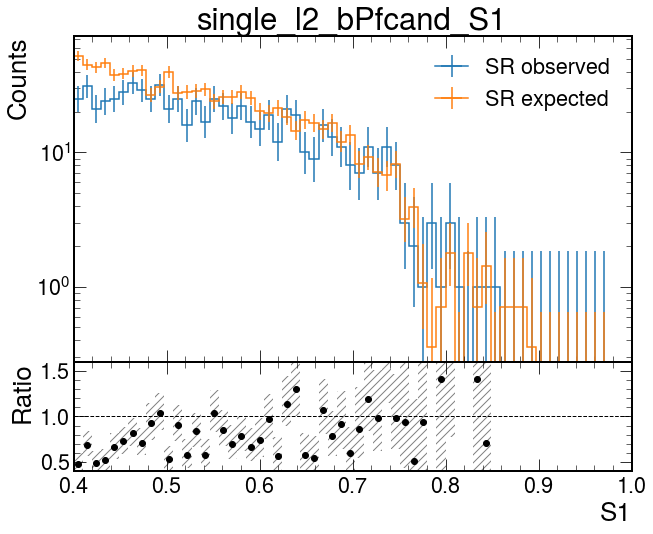

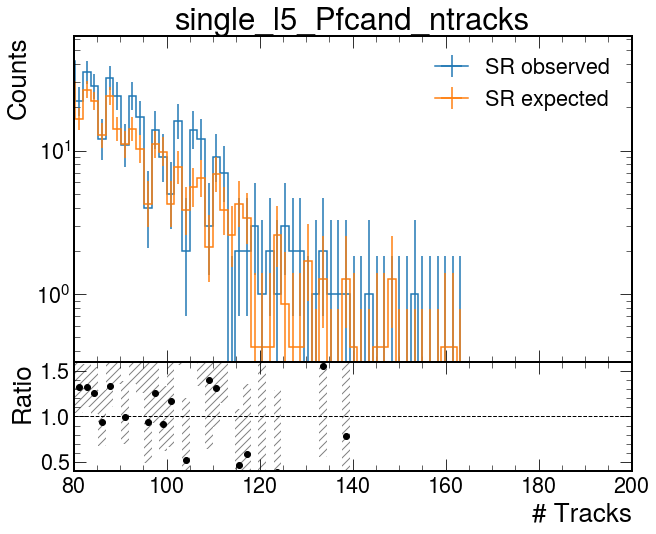

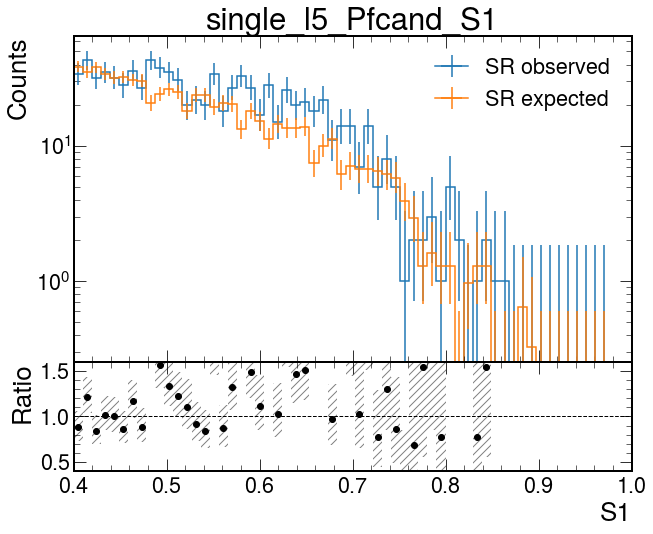

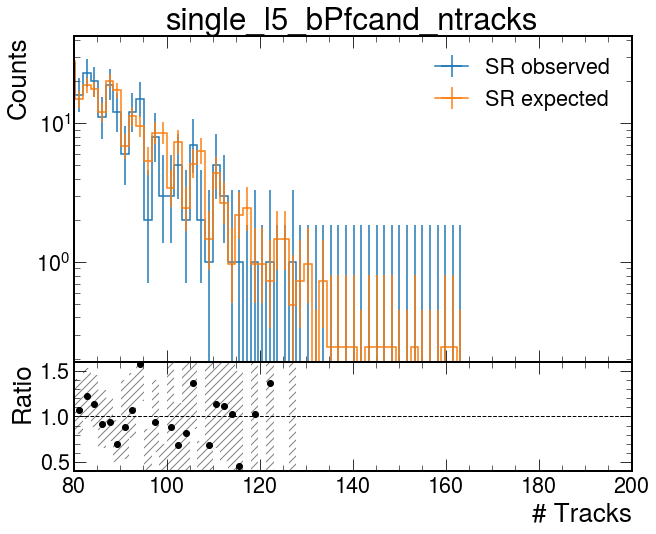

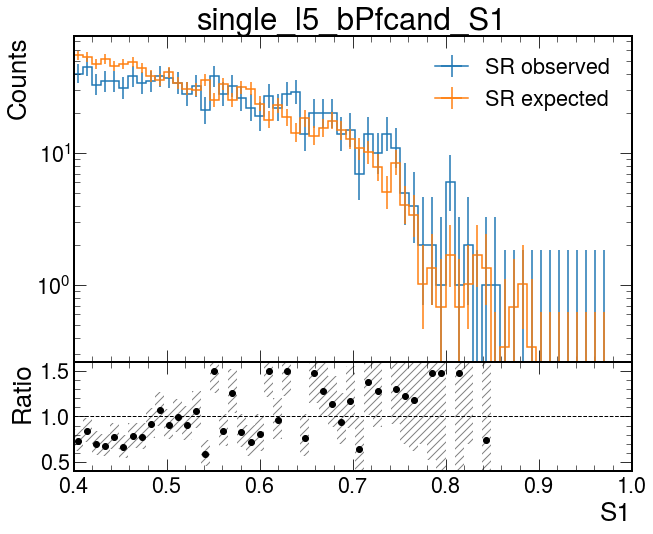

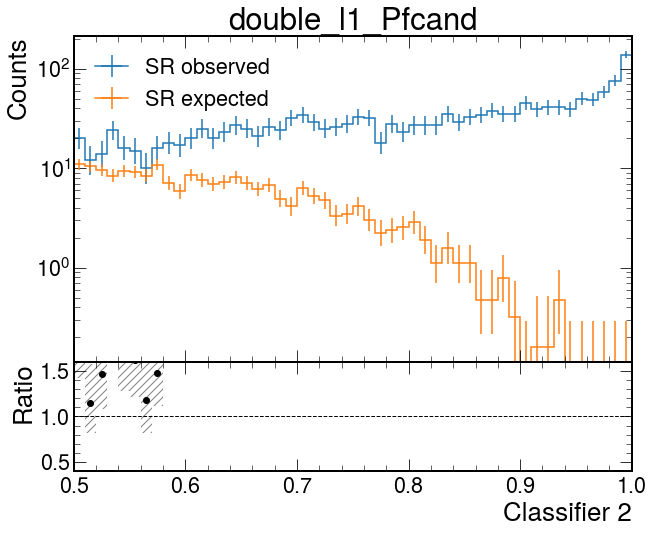

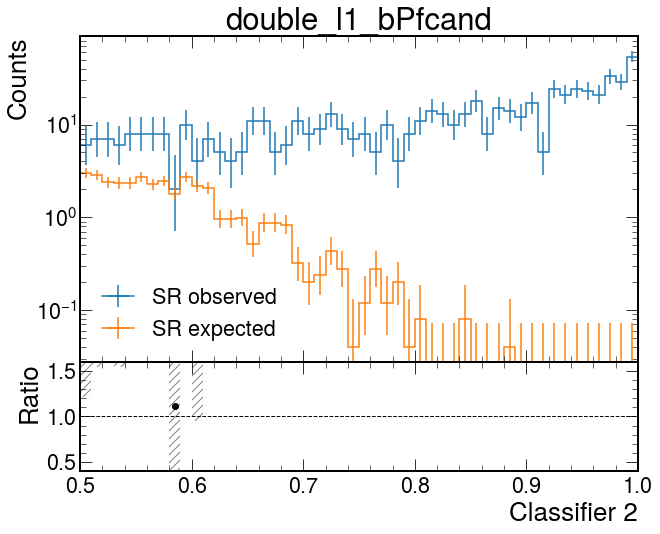

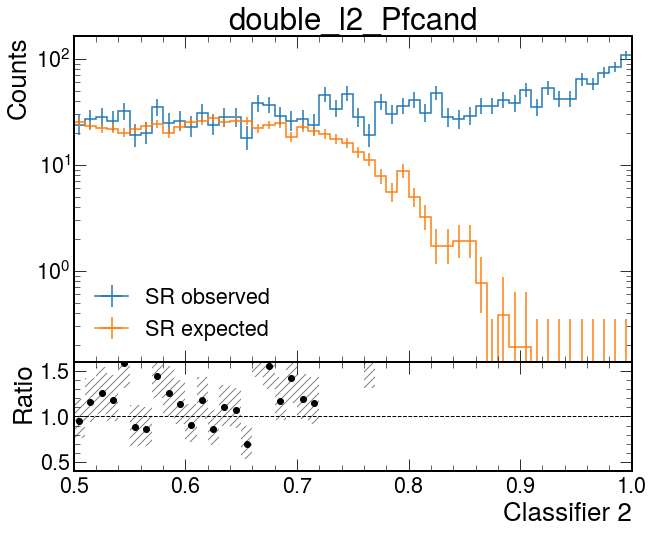

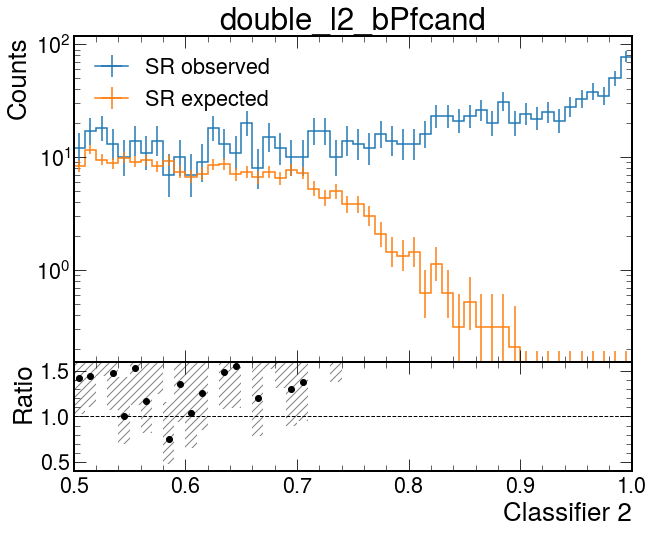

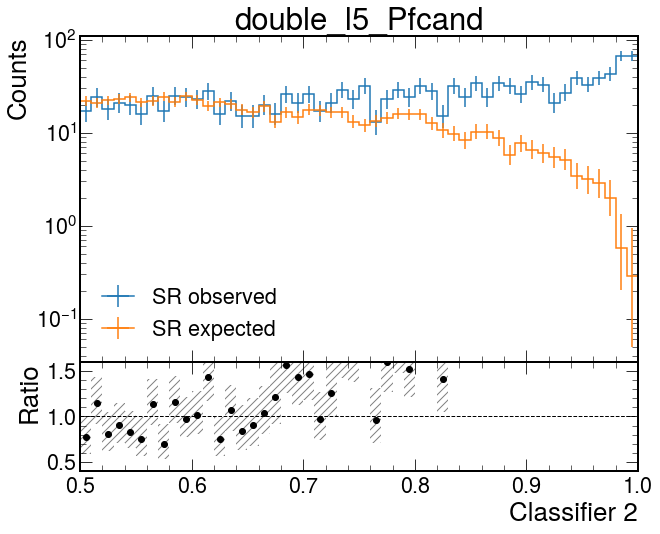

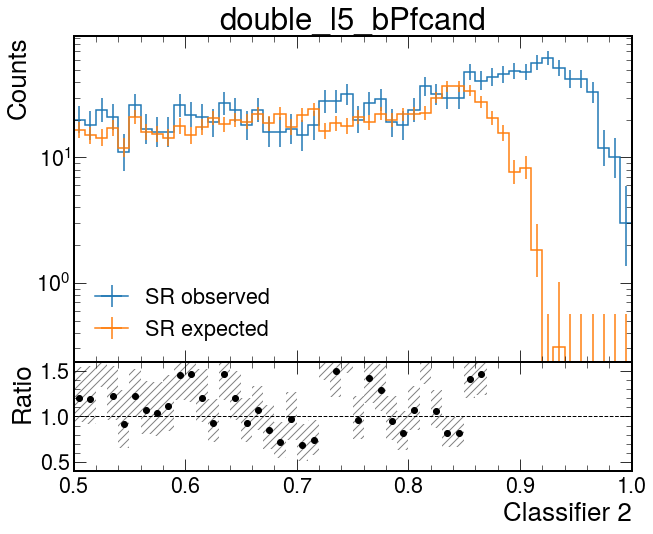

In [40]:
for d, r in zip(dirs, results):
    if 'ntracks' in d:
        disco_var = '# Tracks'
        xmax = 500
        regions = [0.0j, 40j, 80j, 200j]
    elif 'S1' in d:
        disco_var = 'S1'
        xmax = 1.0
        regions = [0.0j, 0.2j, 0.4j, 1.0j]
    elif 'double' in d:
        disco_var = 'Classifier 2'
        xmax = 1.0
        regions = [0.05j, 0.5j, 1.0j]
    
    hist_abcd, hist_abcd_suep = get2dHists(r)
    if len(regions) == 3: SR, SR_exp, ratio = getSRClosure_4regions(hist_abcd, [0.05j, 0.5j, 1.0j], regions)
    elif len(regions) == 4: SR, SR_exp, ratio = getSRClosure_6regions(hist_abcd, [0.05j, 0.5j, 1.0j], regions)
    pres, recs = precision_recall_2variables(r[0],r[1],r[2], [0.5], [regions[-2].imag])
    
    print(d)
    print("\tSR Closure:", round(ratio,2))
    print("\tPrecision:", round(pres[0],2))
    print("\tRecall:", round(recs[0],2))
    
    fig = plt.figure(figsize=(10, 8))
    main, sub = SR.plot_ratio(SR_exp,
                    rp_num_label='SR observed',
                    rp_denom_label='SR expected',
                    rp_uncert_draw_type="bar")
    fig.axes[0].set_title(d)
    fig.axes[0].set_yscale("log")
    fig.axes[0].set_xlim(regions[-2].imag,regions[-1].imag)
    fig.axes[1].set_xlabel(disco_var)
    fig.axes[1].set_ylim(0.4,1.6)
    fig.savefig(out_dir+"{}-ABCD.png".format(d))

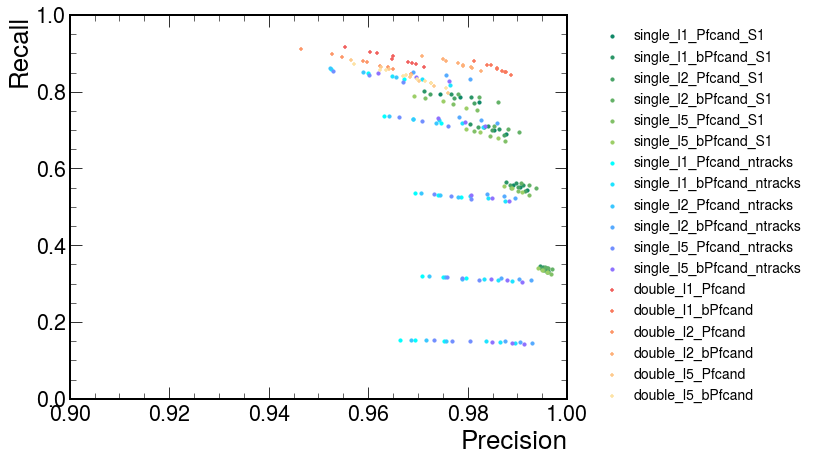

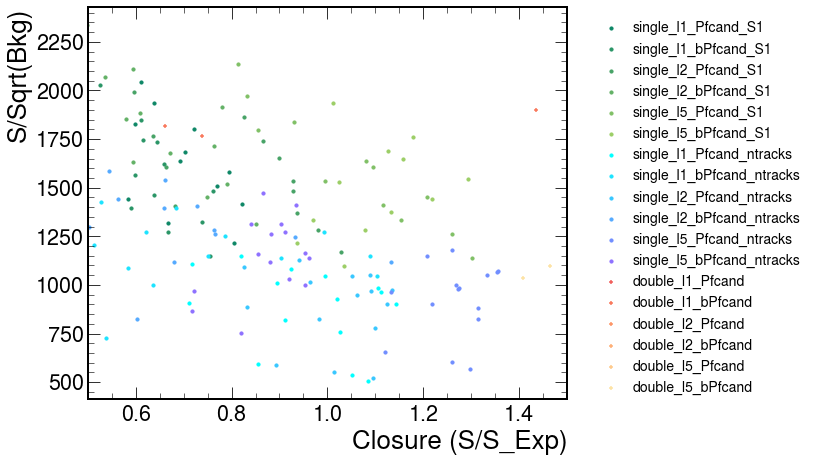

In [20]:
fig = plt.figure(figsize=(12,7))
ax = fig.subplots()

fig2 = plt.figure(figsize=(12,7))
ax2 = fig2.subplots()

cmap = plt.cm.summer(np.linspace(0, 1, len(dirs)+1))
cmap2 = plt.cm.cool(np.linspace(0, 1, len(dirs)+1))
cmap3 = plt.cm.magma(np.linspace(0, 1, len(dirs)+1))

for r, d, c in zip(results, dirs, cmap):
    
    if 'S1' not in d: continue
            
    xsecs = [0.4,0.5,0.6]
    ysecs = [0.4,0.5,0.6,0.7]
    pres, recs = precision_recall_2variables(r[0],r[1],r[2], xsecs, ysecs)
    ratios, sigs = closure_significance_2variables(r, xsecs, ysecs)
        
    ax.scatter(pres, recs, s=10.0, label=d, color=c)
    ax2.scatter(ratios, sigs, s=10.0, label=d, color=c)
    
for r, d, c in zip(results, dirs, cmap2):
    
    if 'ntracks' not in d: continue
    
    xsecs = [0.4,0.5,0.6]
    ysecs = [50,60,70,80,90]
    pres, recs = precision_recall_2variables(r[0],r[1],r[2], xsecs, ysecs)
    ratios, sigs = closure_significance_2variables(r, xsecs, ysecs)
    
    ax.scatter(pres, recs, s=10.0, label=d, color=c)
    ax2.scatter(ratios, sigs, s=10.0, label=d, color=c)
    
for r, d, c in zip(results, dirs, cmap3):
    
    if 'double' not in d: continue
    
    xsecs = [0.4,0.5,0.6]
    ysecs = [0.4,0.5,0.6]
    pres, recs = precision_recall_2variables(r[0],r[1],r[2], xsecs, ysecs)
    ratios, sigs = closure_significance_2variables(r, xsecs, ysecs)
    
    ax.scatter(pres, recs, s=10.0, label=d, color=c, marker='+')
    ax2.scatter(ratios, sigs, s=10.0, label=d, color=c, marker='+')
    
ax.set_xlim(0.9,1)
ax.set_ylim(0.0,1)
ax.set_xlabel("Precision")
ax.set_ylabel("Recall")
ax.legend(fontsize=14, framealpha=1, facecolor='white', shadow=True, bbox_to_anchor=(1.04,1), loc="upper left")
fig.tight_layout()
fig.savefig('{}/precision-recall-curve-2vars'.format(out_dir), bbox_inches='tight')

ax2.set_xlim(0.5,1.5)
#ax2.set_ylim(0.0,1)
ax2.set_xlabel("Closure (S/S_Exp)")
ax2.set_ylabel("S/Sqrt(Bkg)")
ax2.legend(fontsize=14, framealpha=1, facecolor='white', shadow=True, bbox_to_anchor=(1.04,1), loc="upper left")
fig2.tight_layout()
fig2.savefig('{}/sig-closure-curve-2vars'.format(out_dir), bbox_inches='tight')

plt.show()

In [21]:
print(list(enumerate(dirs)))

[(0, 'single_l1_Pfcand_ntracks'), (1, 'single_l1_Pfcand_S1'), (2, 'single_l1_bPfcand_ntracks'), (3, 'single_l1_bPfcand_S1'), (4, 'single_l2_Pfcand_ntracks'), (5, 'single_l2_Pfcand_S1'), (6, 'single_l2_bPfcand_ntracks'), (7, 'single_l2_bPfcand_S1'), (8, 'single_l5_Pfcand_ntracks'), (9, 'single_l5_Pfcand_S1'), (10, 'single_l5_bPfcand_ntracks'), (11, 'single_l5_bPfcand_S1'), (12, 'double_l1_Pfcand'), (13, 'double_l1_bPfcand'), (14, 'double_l2_Pfcand'), (15, 'double_l2_bPfcand'), (16, 'double_l5_Pfcand'), (17, 'double_l5_bPfcand')]


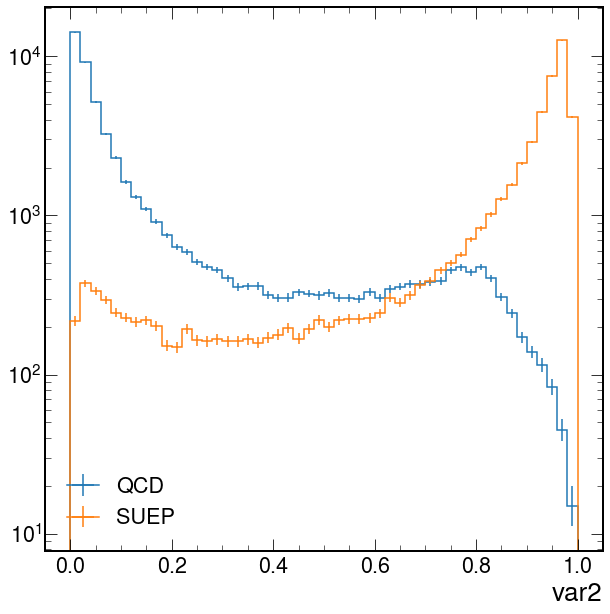

In [37]:
index = 17
d = dirs[index]
r = results[index]

out_dir = out_dir + d
if not os.path.isdir(out_dir): os.system("mkdir " + out_dir)

h, h2 = get2dHists(r)
_ = hep.histplot(h.project(1)[::2j], label="QCD")
_ = hep.histplot(h2.project(1)[::2j], label="SUEP")
plt.legend()
plt.yscale("log")
plt.savefig(out_dir+"var2")

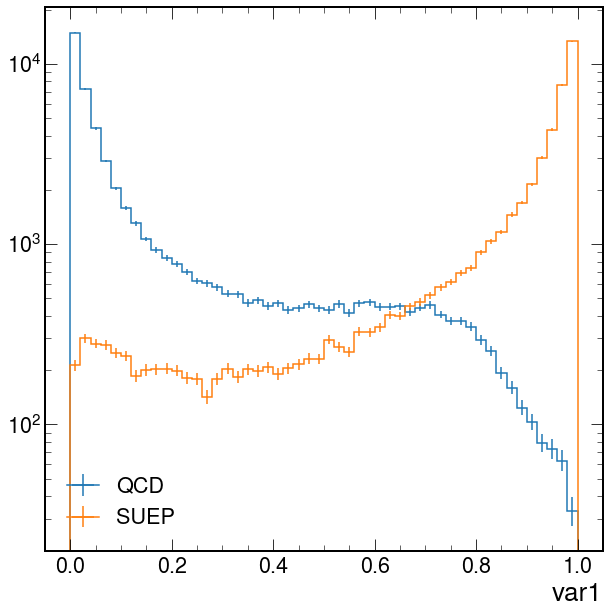

In [36]:
_ = hep.histplot(h.project(0)[::2j], label="QCD")
_ = hep.histplot(h2.project(0)[::2j], label="SUEP")
plt.legend()
plt.yscale("log")
plt.savefig(out_dir+"var1")

1.7790764436801003
0.9675239037256841 0.8431086849450008


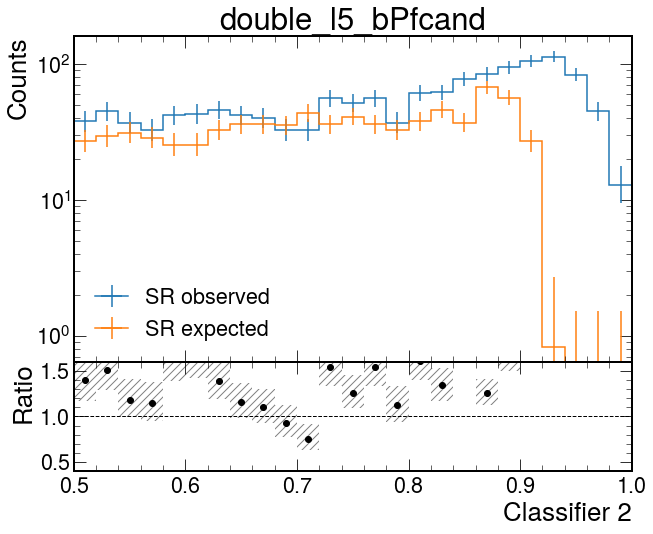

In [39]:
hist_abcd, hist_abcd_suep = get2dHists(r)
xregions = [0.2j, 0.5j, 1.0j]
yregions = [0.2j, 0.5j, 1.0j]
SR, SR_exp, ratio = getSRClosure_4regions(hist_abcd, xregions, yregions)
pres, recs = precision_recall_2variables(r[0],r[1],r[2], [xregions[-2].imag], [yregions[-2].imag])

print(ratio)
print(pres[0], recs[0])

fig = plt.figure(figsize=(10, 8))
main, sub = SR[::2j].plot_ratio(SR_exp[::2j],
                rp_num_label='SR observed',
                rp_denom_label='SR expected',
                rp_uncert_draw_type="bar")
fig.axes[0].set_title(d)
fig.axes[0].set_yscale("log")
fig.axes[0].set_xlim(regions[-2].imag,regions[-1].imag)
fig.axes[1].set_xlabel(disco_var)
fig.axes[1].set_ylim(0.4,1.6)
fig.savefig(out_dir+"{}-ABCD.png".format(d))